<a href="https://colab.research.google.com/github/BlakeMilstead/FraudBot/blob/main/FraudBotFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
import shap
import numpy as np
import pandas as pd
import joblib
import os
import shutil

In [69]:
class FraudDataPreprocessor:
    def __init__(self, url, target='is_fraud'):
        self.url = url
        self.data = None
        self.categories = None
        self.risk_table = None
        self.target = target
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='mean')

    def load_data(self):
        self.data = pd.read_csv(self.url)
        self.data['is_fraud'] = self.data['is_fraud'].astype(str)  # Ensure consistency for filtering
        return self

    def clean_column(self):
        """
        Clean the 'is_fraud' target column by extracting the numeric part.
        """
        self.data['is_fraud'] = self.data['is_fraud'].astype(str)
        self.data['is_fraud'] = self.data['is_fraud'].apply(lambda x: ''.join(filter(str.isdigit, x))[:1])
        self.data['is_fraud'] = self.data['is_fraud'].astype(int)
        return self

    def add_dob_clean(self):
        """
        Add a cleaned 'dob_clean' column by extracting the year from the 'dob' field.
        """
        if 'dob' in self.data.columns:
            self.data['dob_clean'] = self.data['dob'].apply(self.extract_year)
        else:
            raise KeyError("The 'dob' column is missing in the data.")
        return self

    def extract_transaction_time(self):
      """
      Create a column with just the transaction time (hour, minute, second) extracted from a datetime column.
      Assumes the presence of a 'trans_date_trans_time' column in datetime format.
      """
      if 'trans_date_trans_time' in self.data.columns:
          # Ensure the column is in datetime format
          self.data['trans_date_trans_time'] = pd.to_datetime(
              self.data['trans_date_trans_time'], errors='coerce'
          )
          # Extract the time portion (convert to seconds since midnight for numeric use)
          self.data['transaction_time'] = (
              self.data['trans_date_trans_time'].dt.hour * 3600 +
              self.data['trans_date_trans_time'].dt.minute * 60 +
              self.data['trans_date_trans_time'].dt.second
          )
      else:
          raise KeyError("The column 'trans_date_trans_time' is missing in the dataset.")
      return self


    def extract_year(self, dob_value):
        """
        Extract the year from a date string or return NaN if the date is invalid.
        """
        match = re.search(r'(\d{4})', str(dob_value))  # Matches a 4-digit year
        if match:
            return int(match.group(1))  # Return the year as an integer
        else:
            return np.nan  # Return NaN for invalid or malformed entries

    def calculate_distance(self):
        if 'merch_lat' in self.data.columns and 'lat' in self.data.columns and 'merch_long' in self.data.columns and 'long' in self.data.columns:
            R = 6371  # Earth's radius in kilometers
            lat_diff = np.radians(self.data['merch_lat'] - self.data['lat'])
            long_diff = np.radians(self.data['merch_long'] - self.data['long'])
            lat1 = np.radians(self.data['lat'])
            lat2 = np.radians(self.data['merch_lat'])

            a = np.sin(lat_diff / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(long_diff / 2)**2
            self.data['distance'] = 2 * R * np.arcsin(np.sqrt(a))
        else:
            raise KeyError("Latitude or Longitude columns are missing.")
        return self

    def encode_high_risk(self):
        if 'category' in self.data.columns:
            fraud_prop_by_cat = self.data.groupby('category')['is_fraud'].mean()
            self.categories = fraud_prop_by_cat.index
            high_risk_threshold = np.mean(fraud_prop_by_cat)
            risk_encoded = np.where(fraud_prop_by_cat > high_risk_threshold, 1, 0)
            self.risk_table = dict(zip(self.categories, risk_encoded))
            self.data['high_risk'] = self.data['category'].map(self.risk_table)
        else:
            raise KeyError("The 'category' column is missing.")
        return self

    def convert_columns_to_int(self):
      """
      Converts all columns in the dataset to appropriate integer values.
      """
      for column in self.data.columns:
          if self.data[column].dtype == 'object':  # Check for string columns
              # Try to parse as date first
              try:
                  self.data[column] = pd.to_datetime(self.data[column], errors='coerce', format='%Y-%m-%d')  # Specify format to avoid warnings
                  # If successful, convert to the number of days since the epoch
                  self.data[column] = (self.data[column] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
              except Exception:
                  # If not a date, try encoding categorical columns
                  if self.data[column].nunique() < 50:  # A threshold for categorical columns
                      le = LabelEncoder()
                      self.data[column] = le.fit_transform(self.data[column].astype(str))
                  else:
                      # Remove non-numeric characters and try to convert to integer
                      self.data[column] = self.data[column].apply(lambda x: ''.join(filter(str.isdigit, str(x))))
                      # Attempt conversion to integer, handling errors if they occur
                      self.data[column] = pd.to_numeric(self.data[column], errors='coerce', downcast='integer')
          elif self.data[column].dtype in ['int64', 'float64']:
              self.data[column] = pd.to_numeric(self.data[column], errors='coerce', downcast='integer')

      return self


    def preprocess(self):
      """
      Clean, preprocess, and prepare data for modeling.
      """
      self.load_data()
      self.clean_column()
      self.add_dob_clean()
      self.calculate_distance()
      self.encode_high_risk()
      self.extract_transaction_time()  # Include time extraction
      self.convert_columns_to_int()

      # Separate features (X) and target (y)
      X = self.data.drop(columns=[self.target])  # Drop target column from features
      y = self.data[self.target]  # Extract the target column

      self.features = X.columns.tolist()

      # Ensure all columns are numeric
      for col in X.columns:
          if X[col].dtype == 'datetime64[ns]':
              X[col] = X[col].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
          elif X[col].dtype == 'object':
              X[col] = pd.to_numeric(X[col], errors='coerce')

      # Handle missing values in all features
      imputer = SimpleImputer(strategy='mean')  # For numeric features, use mean imputation
      X = imputer.fit_transform(X)  # Impute missing values in the feature set

      # Apply SMOTE to balance the classes
      smote = SMOTE(sampling_strategy='auto', random_state=42)
      X_resampled, y_resampled = smote.fit_resample(X, y)

      scaler = StandardScaler()
      X_resampled = scaler.fit_transform(X_resampled)

      # Split resampled data back into training set
      self.X_train = X_resampled
      self.y_train = y_resampled

      print("Data preprocessing completed.")

      return self.data

    def visualize_data(self):
      cmap = plt.get_cmap('hsv')
      colors = [cmap(i / self.X_train.shape[1]) for i in range(self.X_train.shape[1])]
      plt.figure(figsize=(10, 6))
      for i in range(self.X_train.shape[1]):
        data = self.X_train[:,i]
        plt.scatter(data, np.ones_like(data) * i, color=colors[i], label=f'{self.features[i]}', alpha=.5)
      plt.legend(loc='upper right')
      plt.xlabel('Value')
      plt.ylabel('Feature Index')
      plt.title('Feature Distribution')
      plt.show()
      return self

In [4]:
class FraudDetectionPipeline:
    def __init__(self, data, features, target, model_filename):
        self.data = data
        self.features = features
        self.target = target
        self.model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.kfold_results = []  # To store k-fold results for later review

        # Set the file path for the model
        self.model_filename = f'/content/drive/MyDrive/FraudBot/TrainedModels/{model_filename}/{model_filename}.pkl'

        # Extract the directory path from the model filename
        model_dir = os.path.dirname(self.model_filename)

        # Check if the directory exists, and create it if it doesn't
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
            print(f"Directory {model_dir} created.")


    def save_model(self, hyper=False, kfold=False):
        """Save the trained model to a file on Google Drive."""
        if self.model:
            if hyper:
              joblib.dump(self.model, self.model_filename.replace('.pkl', '_hyper.pkl'))
              joblib.dump(self.X_test, self.model_filename.replace('.pkl', '_X_hyper_test.pkl'))
              joblib.dump(self.y_test, self.model_filename.replace('.pkl', '_y_hyper_test.pkl'))
              joblib.dump(self.X_train, self.model_filename.replace('.pkl', '_X_hyper_train.pkl'))
              joblib.dump(self.y_train, self.model_filename.replace('.pkl', '_y_hyper_train.pkl'))
            else:
              if kfold:
                joblib.dump(self.kfold_results, self.model_filename.replace('.pkl', '_kfold_results.pkl'))
              joblib.dump(self.model, self.model_filename)
              joblib.dump(self.X_test, self.model_filename.replace('.pkl', '_X_test.pkl'))
              joblib.dump(self.y_test, self.model_filename.replace('.pkl', '_y_test.pkl'))
              joblib.dump(self.X_train, self.model_filename.replace('.pkl', '_X_train.pkl'))
              joblib.dump(self.y_train, self.model_filename.replace('.pkl', '_y_train.pkl'))
            print(f"Model saved to {self.model_filename}")
        else:
            print("No model found to save.")

    def load_model(self, hyper=False, kfold=False):
        """Load the trained model from a file if it exists on Google Drive."""
        if hyper:
            if not os.path.exists(self.model_filename.replace('.pkl', '_hyper.pkl')):
                return False
            print(f"Loading hyperparameter tuned model from {self.model_filename.replace('.pkl', '_hyper.pkl')}")
            self.model = joblib.load(self.model_filename.replace('.pkl', '_hyper.pkl'))
            self.X_test = joblib.load(self.model_filename.replace('.pkl', '_X_hyper_test.pkl'))
            self.y_test = joblib.load(self.model_filename.replace('.pkl', '_y_hyper_test.pkl'))
            self.X_train = joblib.load(self.model_filename.replace('.pkl', '_X_hyper_train.pkl'))
            self.y_train = joblib.load(self.model_filename.replace('.pkl', '_y_hyper_train.pkl'))
            return True
        if os.path.exists(self.model_filename):
            if kfold:
              self.kfold_results = joblib.load(self.model_filename.replace('.pkl', '_kfold_results.pkl'))
            self.model = joblib.load(self.model_filename)
            self.X_test = joblib.load(self.model_filename.replace('.pkl', '_X_test.pkl'))
            self.y_test = joblib.load(self.model_filename.replace('.pkl', '_y_test.pkl'))
            self.X_train = joblib.load(self.model_filename.replace('.pkl', '_X_train.pkl'))
            self.y_train = joblib.load(self.model_filename.replace('.pkl', '_y_train.pkl'))
            print(f"Model loaded from {self.model_filename}")
        else:
            print("No saved model found. Proceeding with training.")
        return False

    def delete_model(self, model_filename):
      """Delete the saved model file from Google Drive."""
      if os.path.exists(model_filename):
          os.remove(model_filename)
          print(f"Model file '{model_filename}' has been deleted.")
      else:
          print(f"Model file '{model_filename}' does not exist.")

    def delete_all_in_directory(self, model_filename):
      """
      Delete all files and subdirectories inside the given directory.

      Parameters:
      - directory: The path to the directory to be cleaned.

      """
      # Set the file path for the model
      dir_to_del = f'/content/drive/MyDrive/FraudBot/TrainedModels/{model_filename}/{model_filename}.pkl'

      # Extract the directory path from the model filename
      directory = os.path.dirname(dir_to_del)

      if os.path.exists(directory):
          # Loop through the directory contents
          for item in os.listdir(directory):
              item_path = os.path.join(directory, item)

              # If it's a file, remove it
              if os.path.isfile(item_path):
                  os.remove(item_path)
                  print(f"Deleted file: {item_path}")
              # If it's a directory, remove it recursively
              elif os.path.isdir(item_path):
                  shutil.rmtree(item_path)
                  print(f"Deleted directory: {item_path}")
      else:
          print(f"Directory {directory} does not exist.")

    def preprocess(self):
        # Check if the data is None
        if self.data is None:
            raise ValueError("Data has not been loaded. Please ensure data is provided.")

        # Prepare features and target
        X = self.data[self.features]
        y = self.data[self.target]

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')  # You can also try 'median' or 'most_frequent'
        X = imputer.fit_transform(X)

        # Apply SMOTE to balance the classes
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X, y = smote.fit_resample(X, y)

        print("Pipeline preprocessing completed.")
        return X, y

    def train_baseline_model(self):
        """Train a baseline XGBoost model and evaluate its performance."""
        X, y = self.preprocess()  # Preprocess data

        # Check if the model is already trained and saved
        self.load_model()

        # If model isn't loaded, train it
        if self.model is None:
            # Initialize XGBClassifier model for feature selection
            model = XGBClassifier(device='cuda', tree_method='hist', random_state=42)

            # Perform feature selection to find the best number of features
            best_num_features, best_model, best_features = self.find_best_number_of_features(X, y, model)

            # Use the best number of features for training the model
            X_selected = X[:, best_features]  # Select the best features from the entire dataset

            # Train-test split with selected features
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X_selected, y, test_size=0.2, random_state=42, stratify=y
            )

            # Train the model using XGBClassifier with the selected features
            best_model.fit(self.X_train, self.y_train)

            # Save the trained model to a file
            self.model = best_model  # Save the trained baseline model
            self.save_model()

        # If model is already loaded, skip training and use the existing model
        else:
            print("Using pre-trained model.")

    def train_with_kfold(self, X, y, n_splits=5, tune_hyperparameters=False):
        """Train the model using k-fold cross-validation with optional hyperparameter tuning."""
        # Load the model if it already exists
        self.load_model(hyper=False, kfold=True)

        if self.model is None:  # If no saved model, train a new one
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            fold_results = []

            param_dist = {
                'n_estimators': [50, 100, 200],
                'max_depth': [3, 10, 20],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.5, 0.7, 1.0],
                'colsample_bytree': [0.5, 0.7, 1.0]
            }

            # Initialize the model without any RFE-based best model
            base_model = XGBClassifier(device='cuda', tree_method='hist', random_state=42)

            # Loop through folds and train the model without feature selection
            for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
                print(f"\nTraining fold {fold}...")

                # Split data for this fold
                X_train, X_val = X[train_index], X[test_index]
                y_train, y_val = y[train_index], y[test_index]

                # Hyperparameter tuning with RandomizedSearchCV
                if tune_hyperparameters:
                    print(f"Performing hyperparameter tuning for fold {fold}...")

                    # Perform random search for hyperparameters
                    random_search = RandomizedSearchCV(
                        estimator=base_model,
                        param_distributions=param_dist,
                        n_iter=5,  # Number of random combinations to try
                        cv=3,  # Number of folds for cross-validation
                        verbose=1,
                        random_state=42,
                        n_jobs=-1  # Use all available CPU cores
                    )
                    random_search.fit(X_train, y_train)

                    # Get the best model from random search
                    best_model = random_search.best_estimator_
                    print(f"Best hyperparameters for fold {fold}: {random_search.best_params_}")
                else:
                    # If no tuning is needed, use the original base model
                    best_model = base_model

                # Fit the best model with the selected features and training data
                best_model.fit(X_train, y_train)

                # Evaluate on validation data
                y_pred = best_model.predict(X_val)
                y_pred_proba = best_model.predict_proba(X_val)[:, 1]
                metrics = self.evaluate_model(y_val, y_pred, y_pred_proba)

                # Store results
                fold_results.append({
                    "fold": fold,
                    "metrics": metrics,
                    "best_params": random_search.best_params_ if tune_hyperparameters else None,
                    "y_test": y_val,  # Store true labels for classification report
                    "y_pred": y_pred,  # Store predictions for classification report
                })

                print(f"Metrics for fold {fold}: {metrics}")

            # Save fold results
            self.kfold_results = fold_results

            # Print average metrics across folds
            avg_metrics = {metric: np.mean([result["metrics"][metric] for result in fold_results])
                        for metric in fold_results[0]["metrics"].keys()}
            print("\nAverage Metrics Across All Folds:")
            for metric, value in avg_metrics.items():
                print(f"{metric.capitalize()}: {value:.4f}")

            # Save the trained model
            self.model = best_model
            self.save_model(hyper=False, kfold=True)  # Save the final trained model
        else:
            print("Using pre-trained model for k-fold validation.")

    @staticmethod
    def evaluate_model_print(y_test, y_pred, y_pred_proba):
        """
        Evaluate the model performance using multiple metrics.
        """
        print(f"accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"precision: {precision_score(y_test, y_pred)}")
        print(f"recall: {recall_score(y_test, y_pred)}")
        print(f"f1_score: {f1_score(y_test, y_pred)}")
        print(f"roc_auc: {roc_auc_score(y_test, y_pred_proba)}")

    @staticmethod
    def evaluate_model(y_test, y_pred, y_pred_proba):
        """
        Evaluate the model performance using multiple metrics.
        """
        return {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred_proba)
        }

    def find_best_number_of_features(self, X, y, model, max_features=None):
        """
        Perform RFE to find the best number of features based on model performance.

        Parameters:
        - X: The feature matrix (train data)
        - y: The target vector (train labels)
        - model: The model to be used (e.g., XGBClassifier)
        - max_features: The maximum number of features to consider (optional, default: None, means use all features)

        Returns:
        - best_num_features: The number of features that gave the best model performance
        - best_model: The model trained with the selected features
        - best_features: The list of selected feature indices
        """
        if max_features is None:
            max_features = X.shape[1]

        best_num_features = 0
        best_model = None
        best_features = None
        best_score = 0

        # Loop over the number of features to select
        for num_features in range(1, max_features + 1):
            # Initialize RFE with the current number of features to select
            rfe = RFE(estimator=model, n_features_to_select=num_features)

            # Fit RFE
            X_rfe = rfe.fit_transform(X, y)

            # Split the data into training and validation sets
            X_train, X_val, y_train, y_val = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]

            # Evaluate the model performance (using accuracy as an example)
            score = accuracy_score(y_val, y_pred)  # You can use other metrics like precision, recall, etc.

            # If the score is better than the best score so far, update the best result
            if score > best_score:
                best_score = score
                best_num_features = num_features
                best_model = model
                best_features = rfe.support_  # rfe.support_ gives the selected feature indices

        print(f"Best number of features: {best_num_features} with score: {best_score:.4f}")

        # Return the selected number of features and the corresponding model
        return best_num_features, best_model, best_features

    def view_kfold_results(self):
        """
        Display the results from k-fold training, including classification reports.
        """
        if not self.kfold_results:
            print("No k-fold results found. Please run train_with_kfold first.")
            return

        print("\nK-Fold Results Summary:")
        for result in self.kfold_results:
            print(f"Fold {result['fold']}:")
            print(f"  Metrics: {result['metrics']}")
            if result["best_params"]:
                print(f"  Best Hyperparameters: {result['best_params']}")

            # Add the classification report for each fold
            y_true = result['y_test']
            y_pred = result['y_pred']
            print("  Classification Report:")
            print(classification_report(y_true, y_pred))
            print(f"  Best Model Parameters: {result['best_params']}")

            print("-" * 40)

    def hyperparameter_tuning(self):
        """
        Perform hyperparameter tuning using RandomizedSearchCV, optimizing for recall.
        """
        if self.load_model(hyper=True, kfold=False):
            print("Using pre-trained model for hyperparameter tuning.")
            return
        param_dist = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 10, 20],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.5, 0.7, 1.0],
            'colsample_bytree': [0.5, 0.7, 1.0]
        }
        xgb = XGBClassifier(device='cuda', tree_method='hist', random_state=42)
        random_search = RandomizedSearchCV(
            xgb, param_distributions=param_dist, n_iter=50, cv=5, scoring='recall', n_jobs=-1, random_state=42
        )
        random_search.fit(self.X_train, self.y_train)
        print("Best Hyperparameters:", random_search.best_params_)
        self.model = random_search.best_estimator_  # Save the optimized model
        self.save_model(hyper=True, kfold=False)  # Save the optimized model

    def evaluate_optimized_model(self):
        """
        Evaluate the performance of the optimized model.
        """
        if self.model is None:
            print("No model found. Please train a model first.")
            return

        # Generate predictions
        y_pred_optimized = self.model.predict(self.X_test)
        y_pred_proba_optimized = self.model.predict_proba(self.X_test)[:, 1]

        # Print a performance summary
        print("Optimized XGBoost Performance:")

        # Evaluate with existing metrics
        metrics = self.evaluate_model(self.y_test, y_pred_optimized, y_pred_proba_optimized)
        for key, value in metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")

        # Add classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred_optimized, target_names=['Non-Fraud (0)', 'Fraud (1)']))

    def adjust_threshold_and_evaluate(self, threshold=0.3):
        """
        Adjust the decision threshold and evaluate the performance.
        """
        if self.model is None:
            print("No model found. Please train a model first.")
            return

        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)  # Apply threshold
        print(f"\nEvaluating with threshold: {threshold}")
        metrics = self.evaluate_model(self.y_test, y_pred, y_pred_proba)
        for key, value in metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")

        # Add classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred, target_names=['Non-Fraud (0)', 'Fraud (1)']))

    def explain_model(self):
        """
        Use SHAP to explain the model's predictions.
        """
        if self.model is None:
            print("No model found. Please train a model first.")
            return

        print("Explaining model using SHAP...")
        explainer = shap.Explainer(self.model)
        shap_values = explainer(self.X_train)
        shap.summary_plot(shap_values.values, self.X_train, feature_names=self.features)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['merchant' 'category' 'city' 'state' 'job' 'dob' 'trans_num']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Data preprocessing completed.
Pipeline preprocessing completed.
Pipeline preprocessing completed.
Model loaded from /content/drive/MyDrive/FraudBot/TrainedModels/full_xgboost/full_xgboost.pkl
Using pre-trained model.
Loading hyperparameter tuned model from /content/drive/MyDrive/FraudBot/TrainedModels/full_xgboost/full_xgboost_hyper.pkl
Using pre-trained model for hyperparameter tuning.
Optimized XGBoost Performance:
Accuracy: 0.9708
Precision: 0.9669
Recall: 0.9750
F1_score: 0.9710
Roc_auc: 0.9955

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       0.97      0.97      0.97      2521
    Fraud (1)       0.97      0.97      0.97      2520

     accuracy                           0.97      5041
    macro avg       0.97      0.97      0.97      5041
 weighted avg       0.97      0.97      0.97      5041


Evaluating with threshold: 0.3
Accuracy: 0.9704
Precision: 0.9586
Recall: 0.9833
F1_score: 0.9708
Roc_auc: 0.9955

Classification Report:


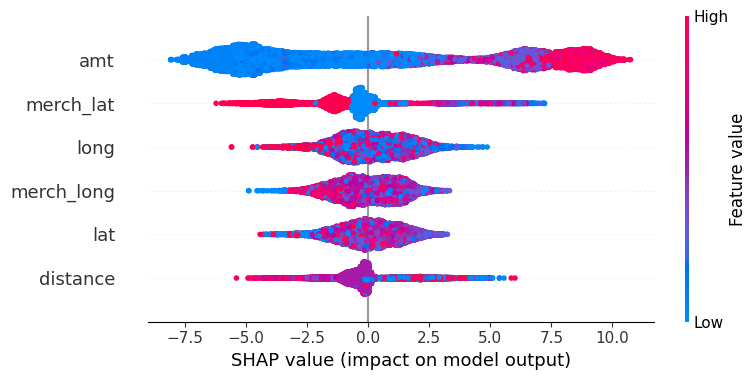

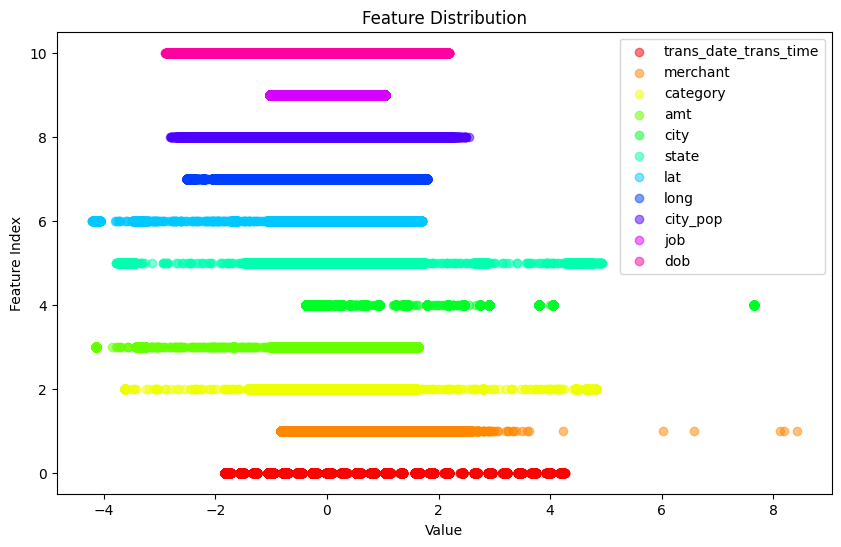

In [71]:
# Load data
url = 'https://raw.githubusercontent.com/BlakeMilstead/FraudBot/refs/heads/main/fraud_data.csv'
process_data = FraudDataPreprocessor(url)
data = process_data.preprocess()

features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'distance', 'high_risk', 'dob_clean', 'transaction_time']
target = 'is_fraud'

# Initialize and run pipeline
pipeline = FraudDetectionPipeline(data, features, target, 'full_xgboost')
pipeline.preprocess()
pipeline.train_baseline_model()
pipeline.hyperparameter_tuning()
pipeline.evaluate_optimized_model()
pipeline.adjust_threshold_and_evaluate(threshold=0.3)  # Adjust threshold for recall optimization
pipeline.explain_model()
process_data.visualize_data()

In [46]:
kfold_pipeline = FraudDetectionPipeline(data, features, target, 'full_kfold')
X, y = kfold_pipeline.preprocess()
kfold_pipeline.train_with_kfold(X, y, n_splits=5, tune_hyperparameters=True)
kfold_pipeline.view_kfold_results()

Pipeline preprocessing completed.
Model loaded from /content/drive/MyDrive/FraudBot/TrainedModels/full_kfold/full_kfold.pkl
Using pre-trained model for k-fold validation.

K-Fold Results Summary:
Fold 1:
  Metrics: {'accuracy': 0.9740130926403492, 'precision': 0.9685007974481659, 'recall': 0.9790407093913744, 'f1_score': 0.9737422329124072, 'roc_auc': 0.9961793222239017}
  Best Hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
  Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2560
           1       0.97      0.98      0.97      2481

    accuracy                           0.97      5041
   macro avg       0.97      0.97      0.97      5041
weighted avg       0.97      0.97      0.97      5041

  Best Model Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
-----------------

Pipeline preprocessing completed.
Pipeline preprocessing completed.
Model loaded from /content/drive/MyDrive/FraudBot/TrainedModels/tuned_xgboost/tuned_xgboost.pkl
Using pre-trained model.
Loading hyperparameter tuned model from /content/drive/MyDrive/FraudBot/TrainedModels/tuned_xgboost/tuned_xgboost_hyper.pkl
Using pre-trained model for hyperparameter tuning.
Optimized XGBoost Performance:
Accuracy: 0.9639
Precision: 0.9549
Recall: 0.9738
F1_score: 0.9642
Roc_auc: 0.9922

Classification Report:
               precision    recall  f1-score   support

Non-Fraud (0)       0.97      0.95      0.96      2521
    Fraud (1)       0.95      0.97      0.96      2520

     accuracy                           0.96      5041
    macro avg       0.96      0.96      0.96      5041
 weighted avg       0.96      0.96      0.96      5041


Evaluating with threshold: 0.3
Accuracy: 0.9593
Precision: 0.9356
Recall: 0.9865
F1_score: 0.9604
Roc_auc: 0.9922

Classification Report:
               precision  

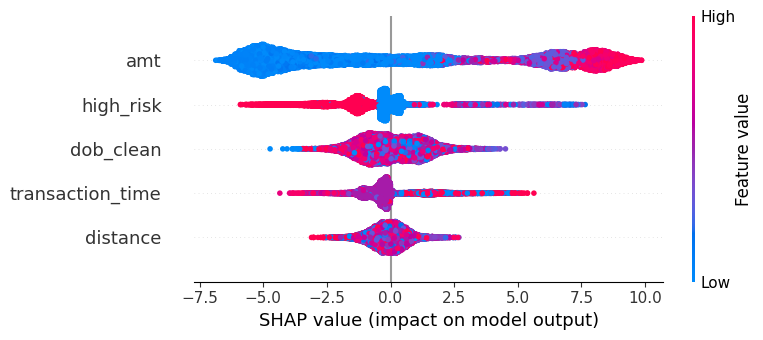

In [47]:
tuned_features = ['high_risk', 'amt', 'distance', 'dob_clean', 'transaction_time']

tuned_pipeline = FraudDetectionPipeline(data, tuned_features, target, 'tuned_xgboost')
tuned_pipeline.preprocess()
tuned_pipeline.train_baseline_model()
tuned_pipeline.hyperparameter_tuning()
tuned_pipeline.evaluate_optimized_model()
tuned_pipeline.adjust_threshold_and_evaluate(threshold=0.3)
tuned_pipeline.explain_model()

In [48]:
kfold_pipeline_tuned = FraudDetectionPipeline(data, tuned_features, target, 'tuned_kfold')
X_t, y_t = kfold_pipeline_tuned.preprocess()
kfold_pipeline_tuned.train_with_kfold(X_t, y_t, n_splits=5, tune_hyperparameters=True)
kfold_pipeline_tuned.view_kfold_results()

Pipeline preprocessing completed.
Model loaded from /content/drive/MyDrive/FraudBot/TrainedModels/tuned_kfold/tuned_kfold.pkl
Using pre-trained model for k-fold validation.

K-Fold Results Summary:
Fold 1:
  Metrics: {'accuracy': 0.9634993056933148, 'precision': 0.9588493807431082, 'recall': 0.9673518742442564, 'f1_score': 0.9630818619582665, 'roc_auc': 0.9931222604292625}
  Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
  Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2560
           1       0.96      0.97      0.96      2481

    accuracy                           0.96      5041
   macro avg       0.96      0.96      0.96      5041
weighted avg       0.96      0.96      0.96      5041

  Best Model Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
---------------